# Synchronicity
## with words by Daisy Lafarge
## for Life Perceives, Jan 20th 2023

Jan 2023, Jonathan Reus


In [1]:
import asyncio
import time
import traceback
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.animation as animation
import random
import IPython
from scipy import integrate
import oscpipe.oscpipe as oscpipe

# Integration using Euler's method
def euler_integrate(dXfunc, X0, t, sim):
    h = t[1] - t[0]
    print(f"Integrating with h={h} (found h={sim.h} in sim)")
    res = [X0]
    for tv in t:
        # Do one Euler integration step for each time step...
        # https://personal.math.ubc.ca/~pwalls/math-python/differential-equations/first-order/
        X0 = X0 + h * dXfunc(X0, tv, sim)
        res.append(X0)
    return np.array(res[:-1])
    
def phase_coherence(angles_vec):
        '''
        Compute global order parameter R_t - mean length of resultant phase vector
        '''
        suma = sum([(np.e ** (1j * i)) for i in angles_vec])
        return abs(suma / len(angles_vec))





In [2]:
# Start an OSCPipe to connect to SC
osc = oscpipe.BaseOSCPipe(
    logger=None,
    bind_ip=('localhost', 1337),
    client_ip=('localhost', 57120),
    osc_keepalive_threshold=30,
    outgoing_addr_prefix='/kuramoto',
)

aloop=asyncio.get_event_loop()
osc_server_task = aloop.create_task(osc.run_server(), name="OSC Server Task")
keepalive_osc_task = aloop.create_task(osc.run_osc_keepalive(), name="OSC Keepalive Task")


Not connected to SuperCollider, awaiting auth request ...


In [4]:
# Some example messages for sanity...
# /python 'sim' simType 't' t_val 'X' [ X1 X2 X3 ... ] 'dX' [ dX1 dX2 dX3 ... ]
await osc.broadcast('sim', ['KuramotoBasic', 't', 0.0, 
                            'X', np.random.rand(20).tolist(), 
                            'dX',np.random.rand(20).tolist()]
                   )
await osc.broadcast('volume', [0.5])

In [ ]:
await osc.broadcast('volume', [0.0]) # Silence...
sim_task

In [6]:
# Kuramoto Simulator Implementation

try:
    sim_task.cancel()
except NameError as e:
    pass
    
# Set up simulation state object
sim = type('KuramotoBasic', (), {})()
sim.name = "KuramotoBasic"
def set_connectivity(sim, connectivity=1.0):
    """Build the connectivity graph"""
    sim.connectivity=connectivity
    graph = nx.erdos_renyi_graph(n=sim.n, p=sim.connectivity)
    sim.connectivity_matrix = nx.to_numpy_array(graph) # connectivity matrix p=1. fully connected
    return graph

sim.set_connectivity = set_connectivity

def kuramoto_derivative(X, t, sim):
    '''
        Compute derivative (dtheta_i/dt) of all nodes at current state.
        Where:
            X: vector of current positions (angles theta) size N=number of nodes
            t: current time (this is an autonomous system, does not vary with t)
            sim: simulation state
    '''
    assert len(X) == len(sim.natural_frequencies) == len(sim.connectivity_matrix), 'Input dimensions do not match, check lengths'

    angles_i, angles_j = np.meshgrid(X, X)
    interactions = sim.connectivity_matrix * np.sin(angles_j - angles_i)  # Aij * sin(j-i)
    dXdt = sim.natural_frequencies + sim.k * interactions.sum(axis=0)  # sum over incoming interactions
    return dXdt

sim.dXfunc = kuramoto_derivative


# Important sim parameters
sim.n=20 # number of oscillators
sim.Xhist=np.atleast_2d(np.zeros(sim.n)).T # History of X values for each oscillator, used by plot
sim.k = 0.72    # global coupling constant K, typical values 0.1-2.0 ... usually phase shift at 0.15
sim.X0 = 2 * np.pi * np.random.random(size=sim.n) # initial positions theta
sim.natural_frequencies = np.random.normal(size=sim.n)  # normal distribution of natural frequencies omega
sim.h = 0.01 # integration time step
sim.t = 0.
sim.initial_volume = 0.5
sim.osc_message_rate = 0.1            # 20fps - delay between updates (OSC & graph) in seconds
sim.steps_per_osc_message = 10     # number of integration time steps calculated per update
sim.set_connectivity(sim, 1.) # p=1. = 100% fully connected network

# Momentary position & velocity
sim.X = sim.X0
sim.dX = np.array([])

# Run sim function...
async def run_sim(sim, num_steps=100, update_every=None):
    try:
        if update_every is not None:
            sim.osc_message_rate = update_every
        sim.step=0
        print(f"RUN SIM for {num_steps} steps, update every {sim.osc_message_rate}s, beginning with step {sim.step} ...")
        startTime = time.time()
        while sim.step < num_steps:

            # Do one Euler step
            sim.dX = sim.dXfunc(sim.X, sim.t, sim)
            sim.X = sim.X + sim.h * sim.dX
            sim.t += sim.h

            # Append sin(X) to Xhist
            sim.Xhist = np.append(sim.Xhist, np.atleast_2d(np.sin(sim.X)).T, 1)
            
            if sim.step % sim.steps_per_osc_message == 0:
                #print(f"simname:{sim.name} -- sim.t:{sim.t}")
                #print(f"Sim.dX: {sim.dX.shape} {sim.dX}")
                if osc is not None:
                    oscmsg = [sim.name, 't', sim.t, 
                        'X', sim.X.tolist(), 
                        'dX', sim.dX.tolist()
                    ]
                    await osc.broadcast('sim', oscmsg)   
                
                await asyncio.sleep(sim.osc_message_rate) # scheduler tick

            sim.step += 1
            
        executionTime = (time.time() - startTime)
        print(f"SIM END after {num_steps} steps and {str(executionTime)} seconds")  
    except Exception as ex:
        traceback.print_exc()
        print(f"Exception: {ex.__class__.__name__}: {str(ex)}")
 

In [10]:
# Run sim
await osc.broadcast('volume', [0.5])

loop=asyncio.get_event_loop()
sim_task=loop.create_task(run_sim(sim, num_steps=100000))

RUN SIM for 100000 steps, update every 0.1s, beginning with step 0 ...


In [35]:
try:
    exception = sim_task.exception()
    if exception is not None:
        raise exception
except asyncio.InvalidStateError as e:
    sim_task.cancel()

sim_task.cancel()
await osc.broadcast('volume', [0.0])

<IPython.core.display.Javascript object>


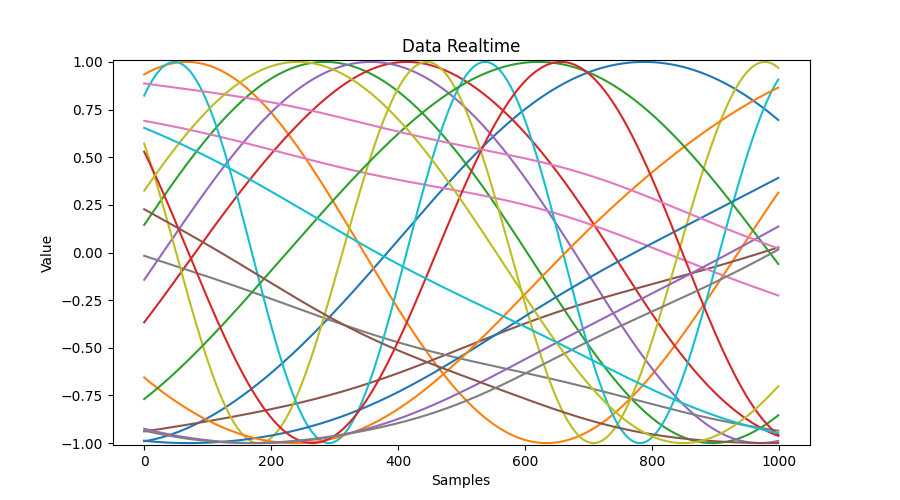

In [8]:
# Create a realtime plot
%matplotlib notebook

plot = type('AnimatedPlot', (), {})()
plot.name = 'AnimatedPlot'
plot.x_len = 1000         # Number of points to display
plot.y_range = [-1.01, 1.01]  # Range of possible Y values to display
plot.x_domain = range(0, 200)
plot.n = sim.n
plot.sim = sim # Sim to plot..

# Create figure, subplot and set y domain
plot.fig = plt.figure()
plot.fig.set_figwidth(9)
plot.fig.set_figheight(5)
plot.ax = plot.fig.add_subplot(1, 1, 1)
plot.ax.set_ylim(plot.y_range)
# Create a 0 line for each sim oscillaor, We will update the lines in animate
plot.lines = []
for i in range(plot.n):
    line, = plot.ax.plot(range(0, plot.x_len), np.zeros(plot.x_len))
    plot.lines.append(line)

# Add labels
plt.title('Data Realtime')
plt.xlabel('Samples')
plt.ylabel('Value')

# This function is called periodically from FuncAnimation
def plot_animate_frame(i, plot):
    #print(f"Animate!{i} {plot}")
    try:
        # Take the last x_len data points from the sim history
        ys = plot.sim.Xhist.T[-plot.x_len:].T
        padding = plot.x_len - ys.shape[1]
        if padding > 0:
            # Leading buffer with zeros
            ys = np.append(np.zeros([ys.shape[0], padding]), ys, 1)

        # Add y to each list
        for i in range(len(ys)):
            # Update each line
            plot.lines[i].set_ydata(ys[i])

        return plot.lines
    except Exception as ex:
        print(f"GOT ERROR IN ANIMATION LOOP: {ex.__class__.__name__}: {str(ex)}")

# Set up plot to call animate() function periodically
ani = animation.FuncAnimation(
    plot.fig,
    plot_animate_frame,
    fargs=(plot,),
    interval=100, # in ms
    blit=True
)

plt.show()

In [31]:
# Manipulate some simulation parameters...
sim.k = 0.3
sim.set_connectivity(sim, 1)
sim.h = 0.005
sim.natural_frequencies = np.random.normal(size=sim.n) * 5
sim.step = 0

In [11]:
await osc.broadcast('volume', [0.7])

In [34]:
sim.k = 0.1
sim.h = 0.001
sim.step=0